# Structure MCMC - 3 Node DAG Experiments

In [1]:

import numpy as np
import pandas as pd

import arviz as az


import networkx as nx
import matplotlib.pyplot as plt

from scores.ScoreAbstract import Score
from scores.bge import BGEscore
from scores.marginal import MarginalLogLikelihood
from scores.dummy import DummyScore


from cache import Cache

import os
import random

from mcmc.MCMCResultsEngine import MCMCResultsEngine


from utils.graph_utils import *
from utils.param_utils import *

from proposals.graph.GraphProposal import GraphProposalUniform

from mcmc.StructureMCMC import StructureMCMC
from mcmc.AugmentedMCMC import AugmentedMCMC


import seaborn as sns
sns.set()

from evaluation.metrics import *



## Data Generation Process

In [39]:
# make a function that generates data for 3 random variables X1, X2, Y where Y = b0 + b1*X1 + b2*X2 + e
def generate_data(n, b0, b1, b2, b3, e, random_seed = 55):
    
    np.random.seed(random_seed)
    
    X1 = np.random.normal(0, 1, n)
    X2 = np.random.normal(0, 1, n)
    
    X3 = b0 + b3*X2 + np.random.normal(0, e, n)
    
    random.seed(random_seed)
    # e follows a normal distribution    
    Y = b0 + b1*X1 + b2*X2 + np.random.normal(0, e, n)
    #Y = b0 + b1*X1 + np.random.normal(0, e, n)
    #Y = b0  + np.random.normal(0, e, n)
    
    #result = pd.DataFrame({'X1': X1, 'X2': X2, 'Y': Y})
    result = pd.DataFrame({'X1': X1, 'X2': X2, 'X3' : X3, 'Y': Y})
    #result = pd.DataFrame({'X1': X1, 'Y': Y})
    
    return result

def true_graph():
    # GRAPHS 3 vars X1 -> Y <- X2
    G1 = nx.DiGraph()
    G1.add_node('X1')
    G1.add_node('X2')
    G1.add_node('X3')
    G1.add_node('Y')

    G1.add_edge('X1', 'Y')
    G1.add_edge('X2', 'Y')
    G1.add_edge('X2', 'X3')

In [40]:
def update_graph_post_prob(graph_list: list, num_nodes : int, node_labels : list, data : pd.DataFrame):
    """given a list of graphs with frequencies, returns a dictionary with posterior probability of the graphs visited during MCMC

    Args:
        graph_list (list): _description_

    Returns:
        _type_: _description_
    """
    
    # Generate the base DAG dictionary with zero frequencies
    dag_dict = gen_base_dag_dict(num_nodes, node_labels)
    
    est_res = {}
    visited_dict_scores = {}
    for g in graph_list.keys():
        if graph_list[g] > 0:
            graph = adjacency_string_to_digraph(g, node_labels)
            visited_dict_scores[g] = BGEscore(data=data, graph=graph).compute()['score']
            est_res[g] = BGEscore(data=data, graph=graph).compute()['score']
        else:
            est_res[g] = 0

        
    total_est =  np.sum(list(est_res.values()))
    for g in est_res.keys():
        est_res[g] = est_res[g] / total_est
    
    return est_res

## Generate Data


In [41]:
SAMPLE_SIZE = 200
BETA0 = -0.2
BETA1 = 1
BETA2 = 0.65
BETA3 = 0.5
ERROR = 2

data = generate_data(SAMPLE_SIZE, BETA0, BETA1, BETA2, BETA3, ERROR)


N = len( data.columns )

data.head()

,X1,X2,X3,Y
0,-1.623731,-0.063255,2.806992,-3.070927
1,-0.101784,0.466660,4.230531,1.187031
2,-1.809791,-0.396638,-3.431465,-0.533201
3,0.262654,0.570157,2.812597,-0.653460
4,0.259953,0.082897,1.193701,-3.161015


## Generate True Posterior Distribution

In [112]:
my_score_str = "BGe Score"
all_dags, total_score = generate_all_dags( data, my_score = my_score_str )
true_posterior_distribution = compute_true_distribution( all_dags )

Total 4 node DAGs generated = 543


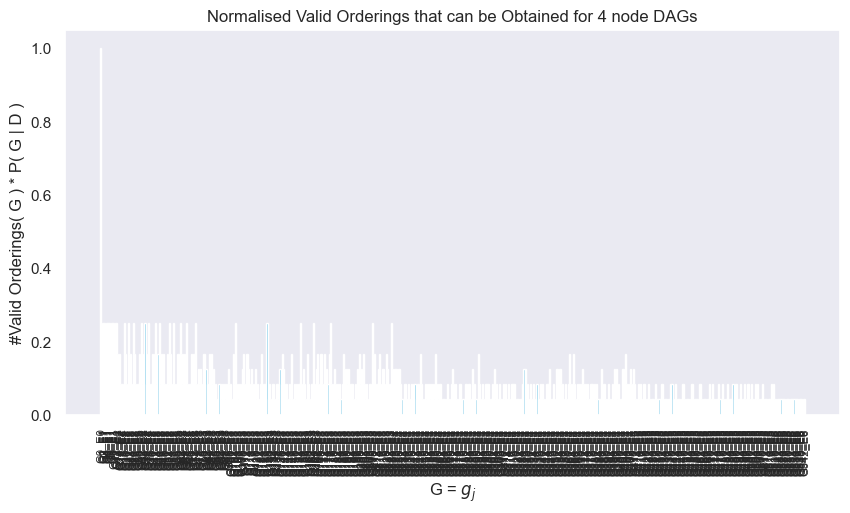

In [43]:
#my_score_str = "BGe Score"

plot_true_posterior_distribution( all_dags, score = 'num_orderings_normalised', figsize=(10, 5), fontsize=8, 
                                    prob_threshold = 0.001, ylabel = "#Valid Orderings( G ) * P( G | D )",
                                    title = f"Normalised Valid Orderings that can be Obtained for {len(data.columns)} node DAGs" )



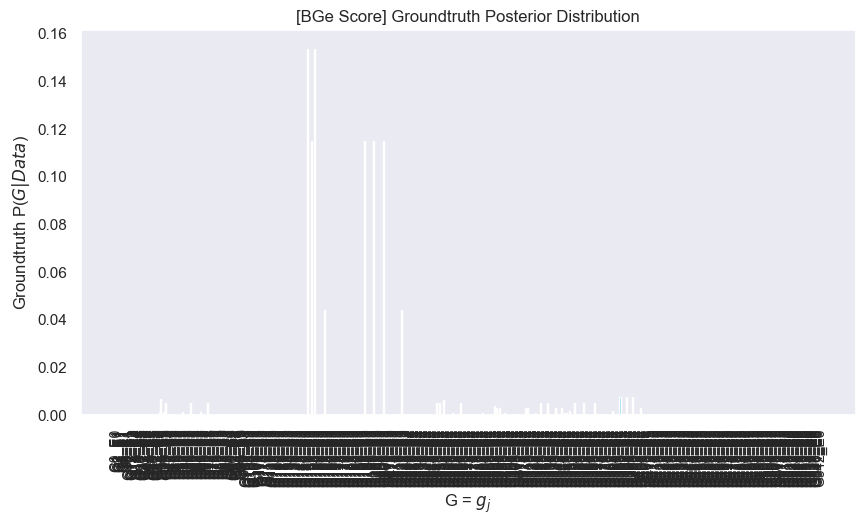

In [44]:
#my_score_str = "BGe Score"

plot_true_posterior_distribution( all_dags, score = 'score_normalised', figsize=(10, 5), 
                                    prob_threshold = 0.000, 
                                    title = f"[{my_score_str}] Groundtruth Posterior Distribution" )


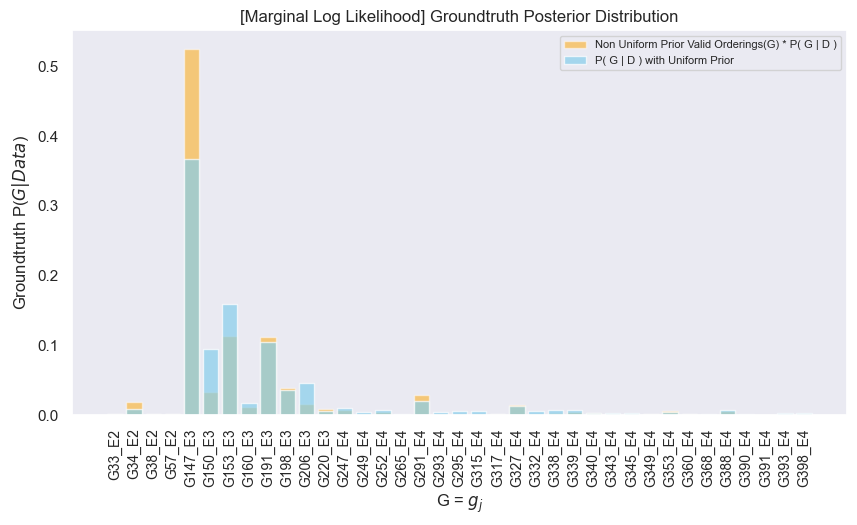

In [109]:
#my_score_str = "BGe Score"

prob_threshold = 0.001
filtered_dags = {k: v for k, v in all_dags.items() if v['score_normalised'] >= prob_threshold}
        
fig, ax = plt.subplots(figsize=(10, 5))
mapper = plot_true_posterior_distribution( filtered_dags, 
                                        score = 'score_ordering_normalised', figsize=(15, 7), 
                                        prob_threshold = prob_threshold, 
                                        title = f"[{my_score_str}] Groundtruth Posterior Distribution", 
                                        alpha=0.5, my_color = 'orange',  ax=ax, label = "Non Uniform Prior Valid Orderings(G) * P( G | D )" )

mapper = plot_true_posterior_distribution( all_dags, 
                                        score = 'score_normalised', figsize=(15, 7), 
                                        prob_threshold = prob_threshold, 
                                        title = f"[{my_score_str}] Groundtruth Posterior Distribution", alpha = 0.7,  ax=ax, label = "P( G | D ) with Uniform Prior" )

ax.legend(loc='upper right', fontsize=8)

In [9]:
graph_indx1 = 10

graph_key1 = list(all_dags.keys())[graph_indx1]
dag = all_dags[graph_key1]['DAG']
plot_graph( dag, figsize=(3, 3), title = f"[{my_score_str}] Groundtruth Graph" )

IndexError: list index out of range

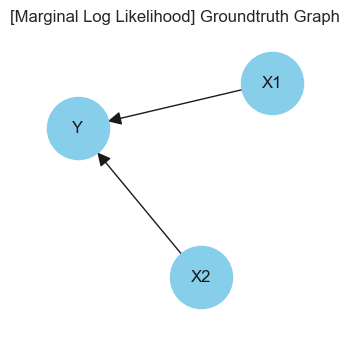

In [ ]:
graph_indx2 = 12

graph_key2 = list(all_dags.keys())[graph_indx2]
dag = all_dags[graph_key2]['DAG']
plot_graph( dag, figsize=(3, 3), title = f"[{my_score_str}] Groundtruth Graph" )

In [ ]:
all_dags[graph_key1]['log_score'] - all_dags[graph_key2]['log_score']

-23.59009162971506

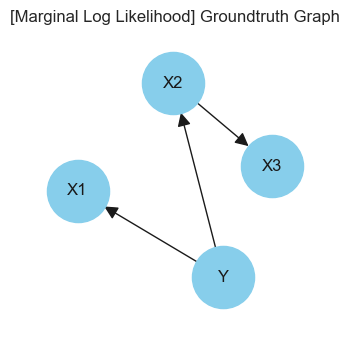

In [ ]:
graph_indx = 198

graph_key = list(all_dags.keys())[graph_indx]
dag = all_dags[graph_key]['DAG']
plot_graph( dag, figsize=(3, 3), title = f"[{my_score_str}] Groundtruth Graph" )

In [ ]:
all_dags[graph_key]

{'DAG': <networkx.classes.digraph.DiGraph at 0x2b9eccb90>,
 'DAG_indx': 198,
 'Freq': 1,
 'num_orderings': 3,
 'num_edges': 3,
 'log_score': -1449.7408419443045,
 'log_score_ordering': -1449.7408419443045,
 'log_score_ordering_scaled': -2.323043845983193,
 'log_score_scaled': -2.323043845983193,
 'score_ordering': 0.2939247322089487,
 'score': 0.09797491073631623,
 'score_normalised': 0.03602297129684531,
 'score_ordering_normalised': 0.03858249497934321,
 'num_orderings_normalised': 0.125}

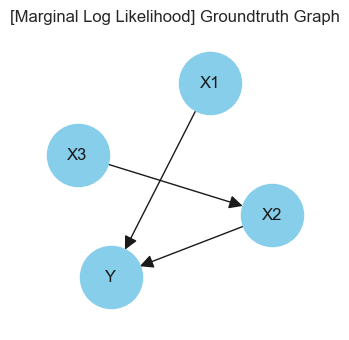

In [ ]:
graph_indx = 153

graph_key = list(all_dags.keys())[graph_indx]
dag = all_dags[graph_key]['DAG']
plot_graph( dag, figsize=(3, 3), title = f"[{my_score_str}] Groundtruth Graph" )

In [ ]:
all_dags[graph_key]

{'DAG': <networkx.classes.digraph.DiGraph at 0x2b9eae190>,
 'DAG_indx': 153,
 'Freq': 1,
 'num_orderings': 2,
 'num_edges': 3,
 'log_score': -1448.2510999412425,
 'log_score_ordering': -1448.2510999412425,
 'log_score_ordering_scaled': -0.8333018429211734,
 'log_score_scaled': -0.8333018429211734,
 'score_ordering': 0.8692237887985483,
 'score': 0.43461189439927417,
 'score_normalised': 0.15979613229093179,
 'score_ordering_normalised': 0.11410003579897669,
 'num_orderings_normalised': 0.08333333333333333}

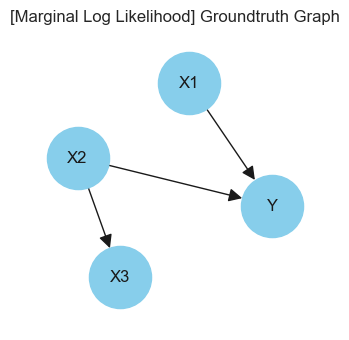

In [ ]:
graph_indx = 147

graph_key = list(all_dags.keys())[graph_indx]
dag = all_dags[graph_key]['DAG']
plot_graph( dag, figsize=(3, 3), title = f"[{my_score_str}] Groundtruth Graph" )

In [ ]:
all_dags[graph_key]

{'DAG': <networkx.classes.digraph.DiGraph at 0x2b9e77a90>,
 'DAG_indx': 147,
 'Freq': 1,
 'num_orderings': 4,
 'num_edges': 3,
 'log_score': -1447.4177980983213,
 'log_score_ordering': -1447.4177980983213,
 'log_score_ordering_scaled': 0.0,
 'log_score_scaled': 0.0,
 'score_ordering': 4.0,
 'score': 1.0,
 'score_normalised': 0.36767546942497725,
 'score_ordering_normalised': 0.5250663282314771,
 'num_orderings_normalised': 0.16666666666666666}

In [ ]:
# inspect two graphs side by side

ID1 = 5
ID2 = 6

graph_key1 = list(all_dags.keys())[ID1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
plot_graph( adjacency_string_to_digraph(list(all_dags.keys())[ID1],
                                        labels = data.columns), 
                                        title = f"Graph ID = {ID1} \nP(G | Data ) = {np.round(true_posterior_distribution[graph_key1], 4)}", ax = ax1 )

graph_key2= list(all_dags.keys())[ID2]
plot_graph( adjacency_string_to_digraph(list(all_dags.keys())[ID2],
                                        labels = data.columns), 
                                        title = f"Graph ID = {ID2} \nP(G | Data ) = {np.round(true_posterior_distribution[graph_key2], 4)}", ax = ax2 )
plt.margins(0.2)
plt.tight_layout()
plt.show()


IndexError: list index out of range

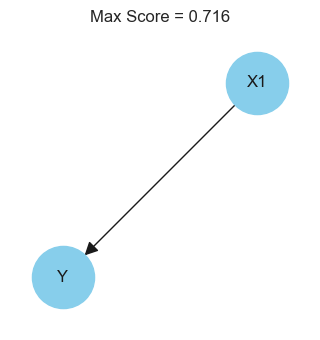

In [ ]:
# get max probability graphs
max_score = max(true_posterior_distribution.values())

max_dags = []
for dag, score in true_posterior_distribution.items():
    if score == max_score:
        max_dags.append(dag)


for g_max in max_dags:
    plot_graph( adjacency_string_to_digraph( g_max, labels=list(data.columns) ), figsize=(3, 3), title=f'Max Score = {np.round(max_score, 4)}' )

## ORDER

## Run Structure MCMC

### Starting with an empty DAG

In [47]:
G_init = nx.DiGraph()

G_init.add_node('X1')
G_init.add_node('X2')
G_init.add_node('X3')

G_init.add_node('Y')

#G_init.add_edge("X1", "Y")
#G_init.add_edge("X2", "Y")
#G_init.add_edge("X2", "X3")



results_analyser = MCMCResultsEngine( )

In [48]:
mcmc_cache = Cache()

burnIn = 0

In [49]:


# Initialize the directed graph with the given nodes
#G_init = nx.DiGraph()
#G_init.add_nodes_from(['X1', 'X2', 'X3', 'Y'])

# Define the edge list
#edges_white = [("X1", "X3")]
#edges_black = [("X1", "X2")]


#black_list = edges_to_adjacency_matrix(edges_black, G_init)
#white_list = edges_to_adjacency_matrix(edges_white, G_init)

#white_list


In [95]:
100000 / 1000

100.0

In [113]:
initial_graph = G_init
initial_order = random.choice(all_valid_orderings(initial_graph))
max_iter = 100000

N = len( data.columns )

proposal_object = GraphProposalUniform(initial_graph, whitelist=None, blacklist=None)
score_object = BGEscore( data=data, graph=initial_graph )
#score_object = MarginalLogLikelihood( data=data, graph=initial_graph )
#score_object = DummyScore( data=data, graph=initial_graph )

#struct_mcmc = StructureMCMC(initial_graph, max_iter, proposal_object, score_object, burnIn)
struct_mcmc = AugmentedMCMC( initial_graph, initial_order, max_iter, proposal_object, score_object, burnIn, pi=0.1)

mcmc_res, accept_rate = struct_mcmc.run()
print(f"ACCEPTANCE RATE = {accept_rate}")

ACCEPTANCE RATE = 0.2334


In [85]:
burnIn = 1000

In [106]:
# compute the approximate posterior distribution
# test
graph_list = struct_mcmc.get_mcmc_res_graphs( mcmc_res )[burnIn:]
approx_posterior_distribution = update_graph_frequencies(graph_list, N, list(data.columns))

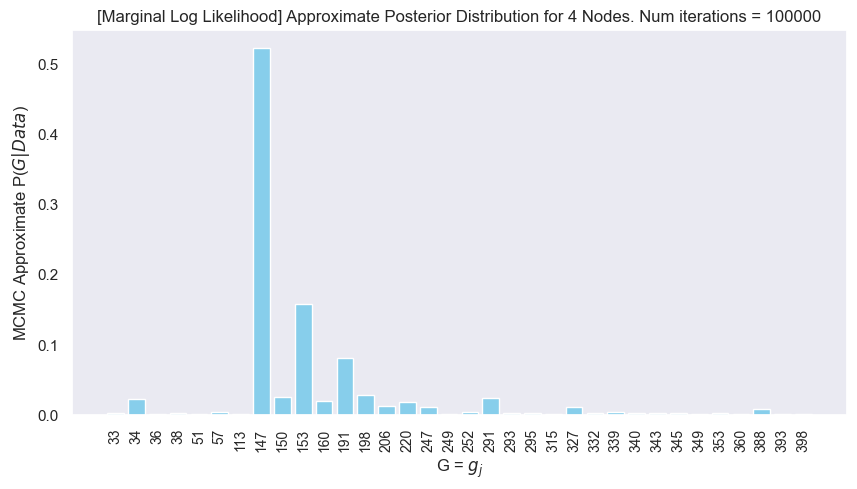

In [107]:
appr_mapper = plot_approx_posterior_distribution(approx_posterior_distribution,  prob_threshold = 0.001, title = f'[{score_object.to_string}] Approximate Posterior Distribution for {len(data.columns)} Nodes. Num iterations = {max_iter}', figsize=(10, 5))


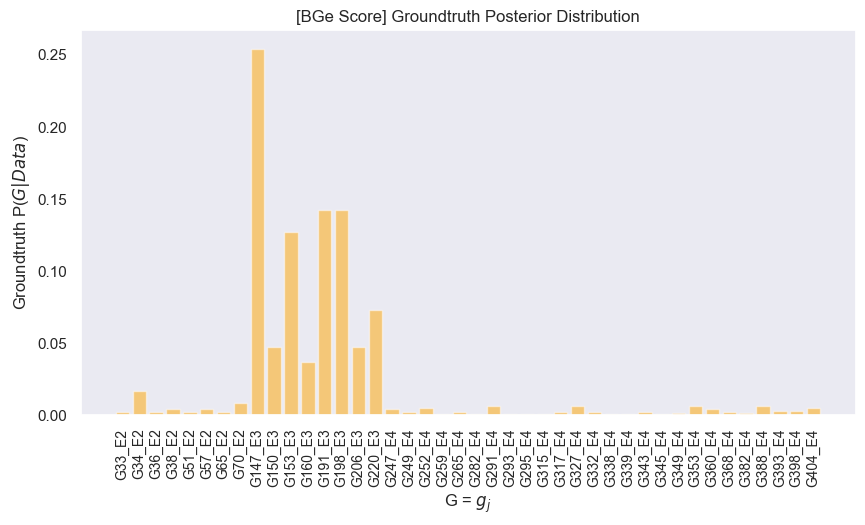

In [88]:
prob_threshold = 0.001
filtered_dags = {k: v for k, v in all_dags.items() if v['score_normalised'] >= prob_threshold}
        
fig, ax = plt.subplots(figsize=(10, 5))
mapper = plot_true_posterior_distribution( filtered_dags, 
                                        score = 'score_ordering_normalised', #figsize=(15, 7), 
                                        prob_threshold = prob_threshold, 
                                        title = f"[{my_score_str}] Groundtruth Posterior Distribution", 
                                        alpha=0.5, my_color = 'orange',  ax=ax )

In [114]:
loss = []
for i in range(1, 100):

    graph_list = struct_mcmc.get_mcmc_res_graphs( mcmc_res )[0:i*1000]
    approx_posterior_distribution = update_graph_frequencies(graph_list, N, list(data.columns))
    
    loss.append(  jensen_shannon_divergence( true_posterior_distribution, approx_posterior_distribution ) )

Text(0.5, 1.0, 'Augmented MCMC Jensen-Shannon Loss (pi=0.1)')

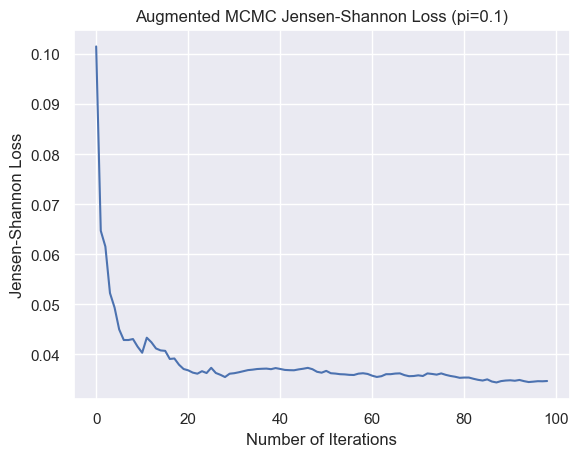

In [115]:
# plot the loss
plt.plot(loss)


plt.xlabel("Number of Iterations")
plt.ylabel("Jensen-Shannon Loss")
plt.title("Augmented MCMC Jensen-Shannon Loss (pi=0.1)")


Text(0.5, 1.0, '[Marginal Likelihood] Augmented MCMC Jensen-Shannon Loss (pi=1)')

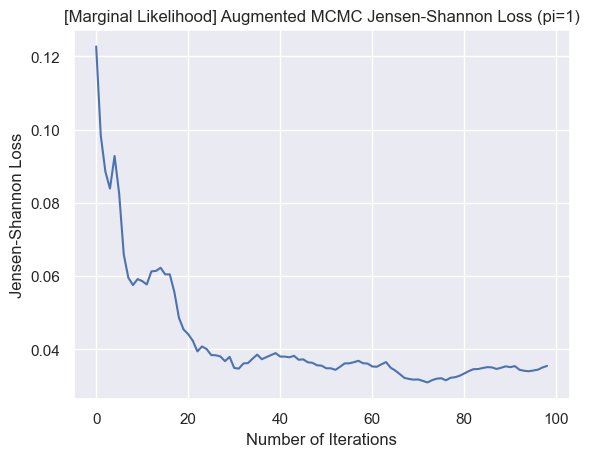

In [111]:
# plot the loss
plt.plot(loss)


plt.xlabel("Number of Iterations")
plt.ylabel("Jensen-Shannon Loss")
plt.title("[Marginal Likelihood] Augmented MCMC Jensen-Shannon Loss (pi=1)")



Text(0.5, 1.0, 'Augmented MCMC Jensen-Shannon Loss (pi=1)')

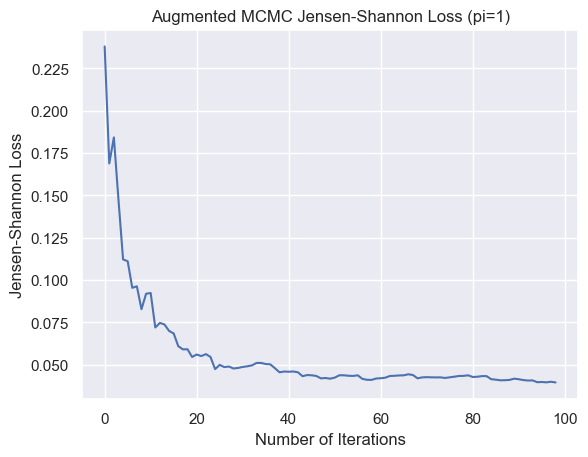

In [102]:
# plot the loss
plt.plot(loss)


plt.xlabel("Number of Iterations")
plt.ylabel("Jensen-Shannon Loss")
plt.title("Augmented MCMC Jensen-Shannon Loss (pi=1)")



In [ ]:
# inspect graphs
ID = 13
plot_graph( adjacency_string_to_digraph( mapper[ID] , 
                                        labels = data.columns), figsize=(3, 3),
                                        title = f"Graph ID = {ID} \nP(G | Data ) = {np.round(approx_posterior_distribution[mapper[ID]], 4)}" )

TypeError: 'NoneType' object is not subscriptable

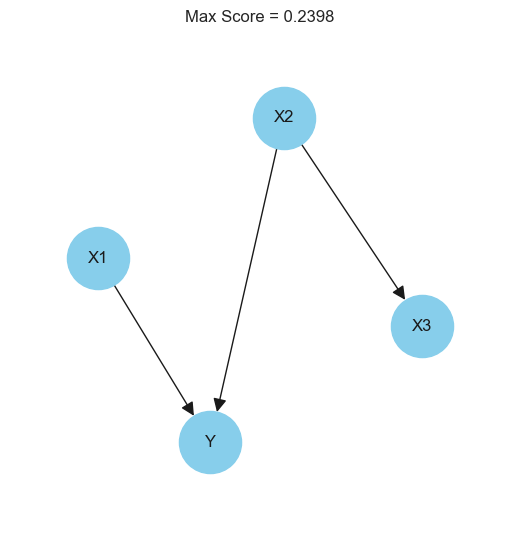

In [94]:
# get max probability graphs
max_score = max(approx_posterior_distribution.values())

max_dags = []
for dag, score in approx_posterior_distribution.items() :
    if score == max_score:
        max_dags.append(dag)


for g_max in max_dags:
    plot_graph( adjacency_string_to_digraph( g_max, labels=list(data.columns) ), figsize=(5, 5), title=f'Max Score = {np.round(max_score, 4)}' )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


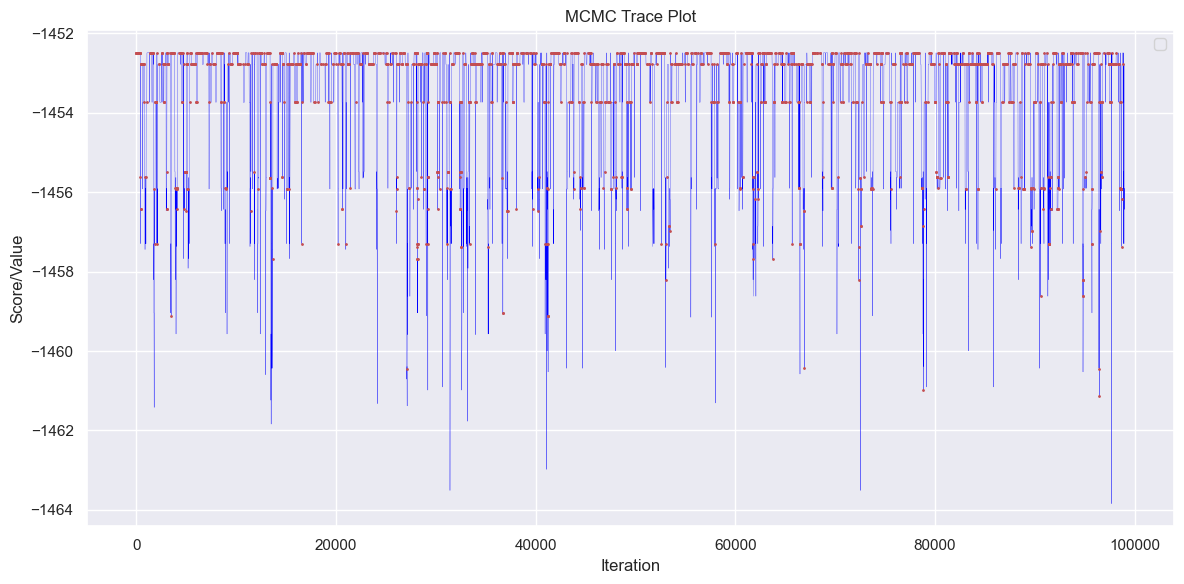

In [90]:
results_analyser.trace_plot(struct_mcmc, mcmc_res, burnIn )


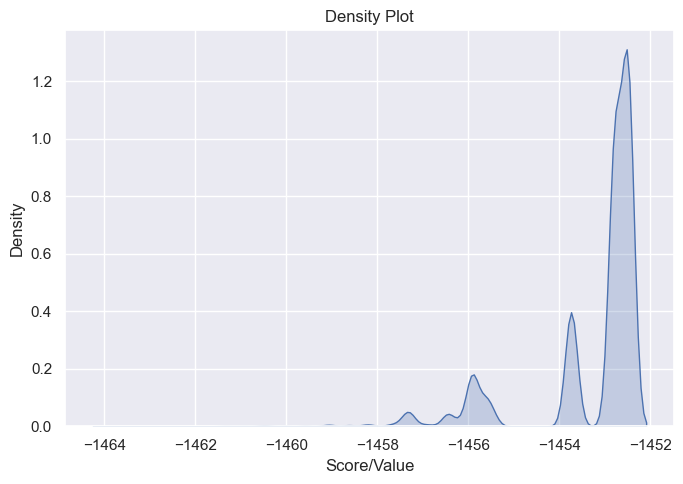

In [91]:
results_analyser.density_plot(struct_mcmc, mcmc_res, burnIn, figsize=(7, 5) )

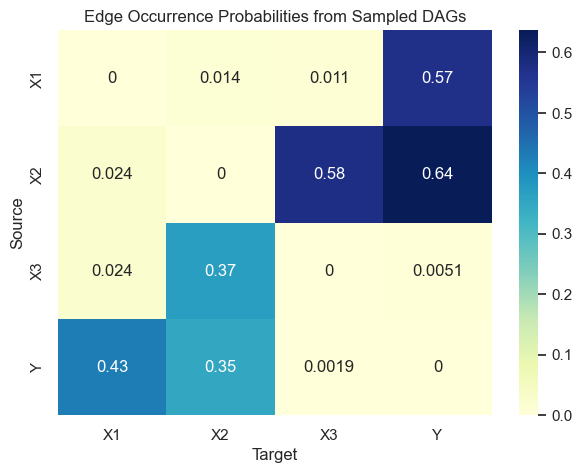

In [92]:
results_analyser.mcmc_edge_frequency_heatmap( struct_mcmc, mcmc_res, burnIn, figsize=(7, 5) )

## Comparing Both Distributions



### Jensen Shannon Divergence

In [93]:
diverg = jensen_shannon_divergence( true_posterior_distribution, approx_posterior_distribution )
diverg

0.0389823833070668

### Mean Square Error

In [71]:
mse = mean_squared_error(true_posterior_distribution, approx_posterior_distribution )
mse

0.01612259297253496

### Mean Absolute Error

In [72]:
mae = mean_absolute_error( true_posterior_distribution, approx_posterior_distribution )
mae

0.4217376647930678

### True Posterior Distribution vs Approximated Posterior Distribution

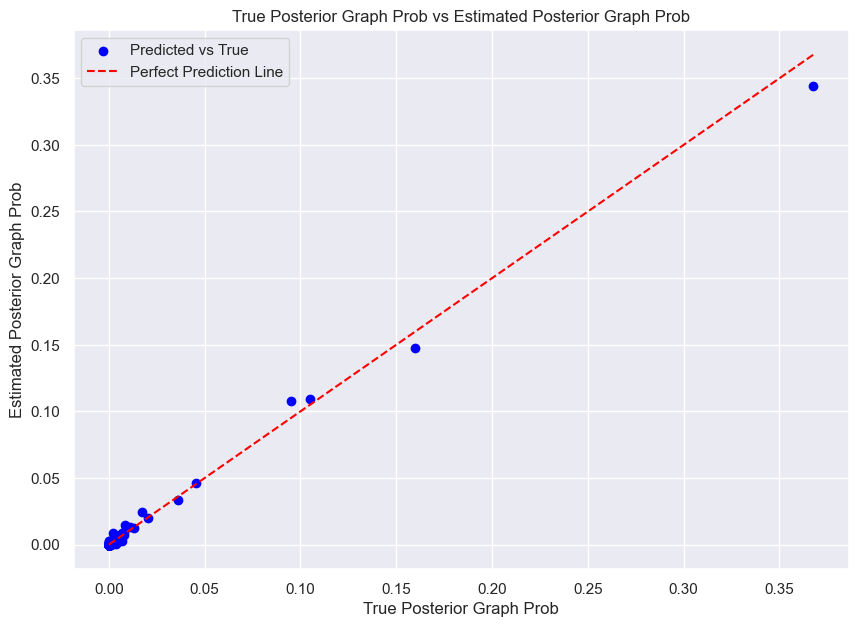

In [ ]:
results_analyser.plot_true_posterior_vs_approx_posterior(true_posterior_distribution, approx_posterior_distribution )


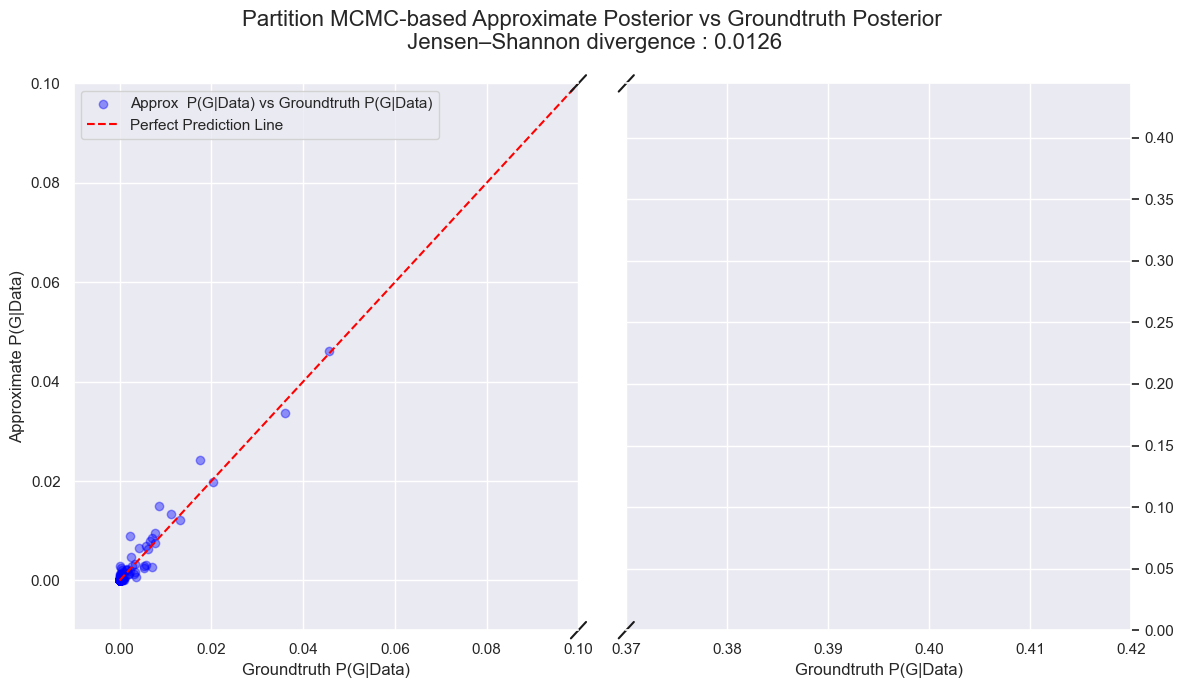

In [ ]:
import matplotlib.gridspec as gridspec



# Create a figure and a gridspec
fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 3])

ZOOM1_X1 = -0.01
ZOOM1_X2 = 0.1

ZOOM1_Y1 = -0.01
ZOOM1_Y2 = 0.1

ax0 = plt.subplot(gs[0])
ax0.scatter(list(true_posterior_distribution.values()), list(approx_posterior_distribution.values()), color='blue', alpha = 0.4,  label='Approx  P(G|Data) vs Groundtruth P(G|Data)')
ax0.set_xlim(ZOOM1_X1, ZOOM1_X2)
ax0.set_ylim(ZOOM1_Y1, ZOOM1_Y2)

ax0.spines['right'].set_visible(False)
ax0.set_ylabel('Approximate P(G|Data)')
ax0.set_xlabel('Groundtruth P(G|Data)')

ax0.plot([min(true_posterior_distribution.values()), max(true_posterior_distribution.values())], 
         [min(true_posterior_distribution.values()), max(true_posterior_distribution.values())], color='red', linestyle='--', label='Perfect Prediction Line')

ax0.grid(True)
plt.legend()


ZOOM2_X1 = 0.37
ZOOM2_X2 = 0.42

# Create the right subplot (0.7 to 1)
ax1 = plt.subplot(gs[1])
ax1.scatter(list(true_posterior_distribution.values()), list(approx_posterior_distribution.values()), color='blue', alpha = 0.4)
ax1.set_xlim(ZOOM2_X1,ZOOM2_X2 )
ax1.set_ylim(min(approx_posterior_distribution.values()), max(approx_posterior_distribution.values())+0.1)
ax1.spines['left'].set_visible(False)
ax1.yaxis.tick_right()
ax1.set_xlabel('Groundtruth P(G|Data)')

ax1.plot([min(true_posterior_distribution.values()), max(true_posterior_distribution.values())], 
         [min(true_posterior_distribution.values()), max(true_posterior_distribution.values())], color='red', linestyle='--', label='Perfect Prediction Line')

ax1.grid(True)

# Adding the "broken" axis effect using diagonals
d = .015
kwargs = dict(transform=ax0.transAxes, color='k', clip_on=False)
ax0.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax0.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax1.transAxes)
ax1.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax1.plot((-d, +d), (-d, +d), **kwargs)

# Title for the entire figure
fig.suptitle(f'Partition MCMC-based Approximate Posterior vs Groundtruth Posterior\n Jensen–Shannon divergence : {np.round(diverg,4)}', fontsize=16)

plt.tight_layout()

plt.show()

# todo, put in a different color the score of the data genrator graph


## Error vs Num Samples

- change the noise
- change the number of samples
- change the number of nodes


### Sample parameters from graph

In [ ]:
G = nx.DiGraph()
G.add_nodes_from(['X1', 'X2', 'X3', 'Y'])
G.add_edges_from((("X1", "Y"),("X2","Y"),("X2","X3")))
DAG = get_adjacency_matrix(G)
n = len(data.columns)
Imat = np.eye(n)
U = pd.DataFrame(Imat, index=data.columns, columns=data.columns)
U

,X1,X2,X3,Y
X1,1.0,0.0,0.0,0.0
X2,0.0,1.0,0.0,0.0
X3,0.0,0.0,1.0,0.0
Y,0.0,0.0,0.0,1.0


In [ ]:
score_object = BGEscore( data=data, graph=G )
rDAG_NIG(1, DAG, score_object, U)['L'][0]

,X1,X2,X3,Y
X1,1.0,0.0,0.000000,-0.819945
X2,0.0,1.0,-0.306811,-0.676914
X3,0.0,0.0,1.000000,0.000000
Y,0.0,0.0,0.000000,1.000000
